In [35]:
import pandas as pd
from operator import attrgetter
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import os
import plotly.express as px

In [36]:
olist_customers_dataset = pd.read_csv('olist_customers_dataset.csv')
olist_order_items_dataset = pd.read_csv('olist_order_items_dataset.csv')
olist_orders_dataset= pd.read_csv('olist_orders_dataset.csv')


# Задача 1.
Оценить месячный retention в оформление заказа с помощью когортного анализа

In [37]:
# Соединяю два датасета
df_delivered_order_1 =olist_orders_dataset \
        .merge(olist_customers_dataset[['customer_id', 'customer_unique_id']],how= 'left',on ='customer_id')

In [38]:
# Извлекаю только успешные заказы
df_delivered_order = olist_order_items_dataset\
                     .merge(df_delivered_order_1[df_delivered_order_1['order_status']=='delivered'], on= 'order_id')

In [39]:
# Преобразовываю даты
df_delivered_order['shipping_limit_date']= pd.to_datetime(df_delivered_order['shipping_limit_date'])
df_delivered_order['order_purchase_timestamp']= pd.to_datetime(df_delivered_order['order_purchase_timestamp'])
df_delivered_order['order_approved_at']= pd.to_datetime(df_delivered_order['order_approved_at'])
df_delivered_order['order_delivered_carrier_date']= pd.to_datetime(df_delivered_order['order_delivered_carrier_date'])
df_delivered_order['order_delivered_customer_date']= pd.to_datetime(df_delivered_order['order_delivered_customer_date'])
df_delivered_order['order_estimated_delivery_date']= pd.to_datetime(df_delivered_order['order_estimated_delivery_date'])

In [40]:
# Расчет первого заказа для каждого клиента
df_delivered_order['period_mount'] = df_delivered_order['order_purchase_timestamp'].dt.to_period('M')
df_delivered_order['period_day'] = df_delivered_order['order_purchase_timestamp'].dt.to_period('D')

In [41]:
# Расчет месяца и дня заказа
df_delivered_order['cohort_mount'] = df_delivered_order.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
df_delivered_order['cohort_day'] = df_delivered_order.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('D')

In [42]:
# Расчет разницы в месяцах между заказами 
df_delivered_order['period_number_mount']= np.floor((df_delivered_order['period_day']- df_delivered_order['cohort_day'])
                    .apply(attrgetter('n'))/30)

In [43]:
# Создание когортную таблицу
df_cohort = df_delivered_order.groupby(['cohort_mount','period_number_mount']).agg({'customer_unique_id':'nunique'}).reset_index()

In [44]:
# Pivon-таблица для расчета retention rate
cohort_pivot= df_cohort.pivot_table(index = 'cohort_mount', columns='period_number_mount', values='customer_unique_id')
cohort_pivot

period_number_mount,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort_mount,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,262.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,1.0,1.0
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,717.0,2.0,NaN,4.0,1.0,1.0,2.0,2.0,NaN,NaN,...,4.0,3.0,2.0,NaN,2.0,2.0,2.0,1.0,NaN,NaN
2017-02,1628.0,2.0,3.0,6.0,4.0,2.0,4.0,1.0,2.0,4.0,...,6.0,1.0,3.0,2.0,1.0,1.0,3.0,NaN,NaN,NaN
2017-03,2503.0,7.0,13.0,11.0,3.0,2.0,9.0,4.0,6.0,6.0,...,4.0,4.0,3.0,7.0,2.0,3.0,2.0,NaN,NaN,NaN
2017-04,2256.0,8.0,6.0,1.0,6.0,8.0,6.0,10.0,5.0,6.0,...,3.0,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN
2017-05,3451.0,14.0,14.0,8.0,13.0,11.0,11.0,4.0,10.0,9.0,...,11.0,6.0,3.0,7.0,4.0,NaN,NaN,NaN,NaN,NaN
2017-06,3037.0,13.0,15.0,11.0,5.0,16.0,9.0,6.0,4.0,10.0,...,9.0,3.0,9.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# Извлекаю нулевой месяц
cohort_size = cohort_pivot.iloc[:, 0]

In [46]:
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

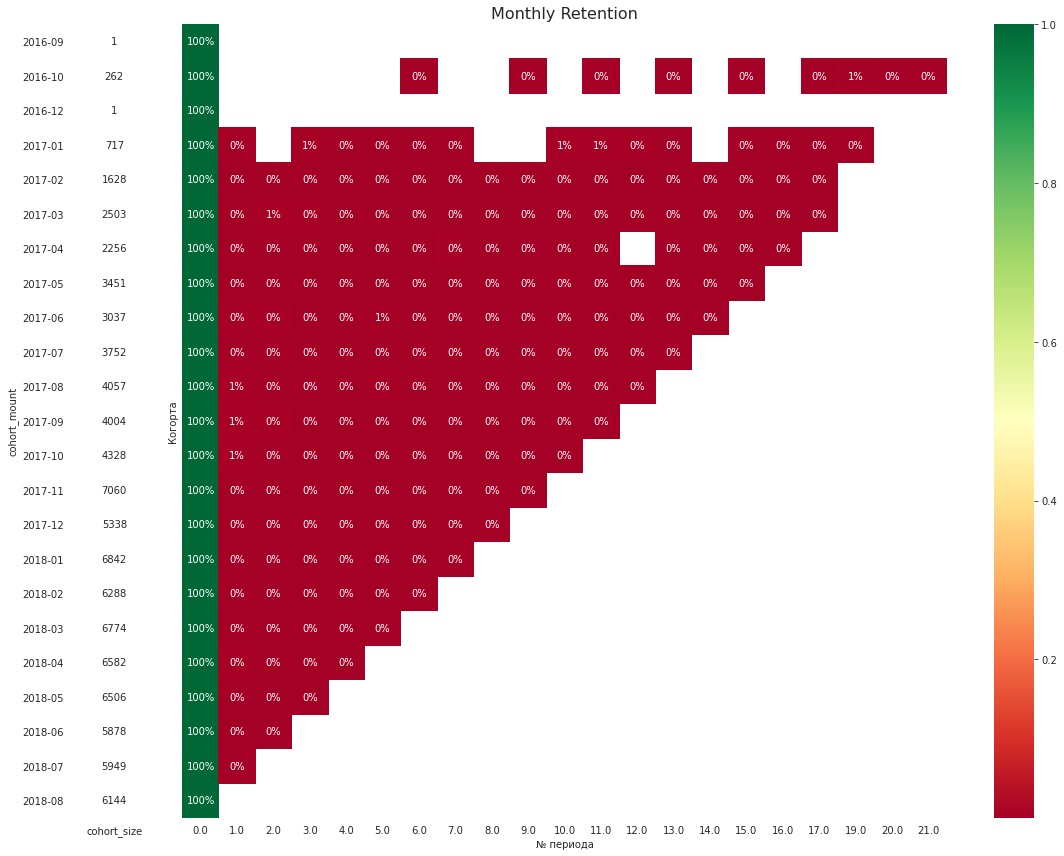

In [47]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()


In [48]:
# Считаю медиану 
retention_matrix[1.0].median()

0.0035460992907801418

In [49]:
# Когорта с самым высоким retention на 3-й месяц
retention_matrix[3.0].sort_values(ascending=False).index[0]

Period('2017-01', 'M')

# Задача 2. 
Определить, существует ли product/market fit у маркетплейса.



In [50]:
# На основании ретеншина продукт/маркетфит отсутствует. Низкий уровень возвращаемости  и отсутствие роста активности
# пользователей указывают на то, что продукт не соответствует потребностям рынка. 
# Вывод: нужно сконцентрироваться на удержании клиентов в продукте.

# Задача 3.
Определить 5 основных метрик, на которых продакт может сконцентрироваться, чтобы максимизировать прибыль компании.

Метрика 1.
Рост продаж 
 


In [51]:
# Объединаю два датасета 
order_customers= olist_orders_dataset.merge(olist_customers_dataset, on='customer_id')

In [52]:
# Объединаю два датасета и фильтрую по доставленным заказам 
delivered_order = olist_order_items_dataset.merge(order_customers, how = 'left', on = 'order_id')
delivered_order= delivered_order.query("order_status=='delivered'")

In [53]:
# Преобразовываю даты
delivered_order['order_purchase_timestamp']= pd.to_datetime(delivered_order['order_purchase_timestamp'])

In [54]:
# Извлекаю месяц заказа
delivered_order['period_mount'] = delivered_order['order_purchase_timestamp'].dt.to_period('M')

In [55]:
# Сколько и в какой месяц сделали заказов на маркетплейсе
delivered_order_mount = delivered_order.groupby('period_mount',as_index =False).agg({'order_id':'count'})\
                        .rename(columns={'order_id':'count_order_id'})
delivered_order_mount

,period_mount,count_order_id
0,2016-09,3
1,2016-10,313
2,2016-12,1
3,2017-01,913
4,2017-02,1858
5,2017-03,2897
6,2017-04,2569
7,2017-05,4004
8,2017-06,3489
9,2017-07,4416


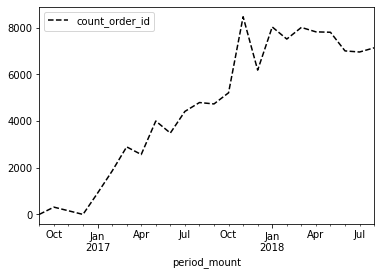

In [56]:
# Динамика
delivered_order_mount.plot(x='period_mount',y='count_order_id',style='k--')

Метрика № 2
Колисчество уникальных клиентов

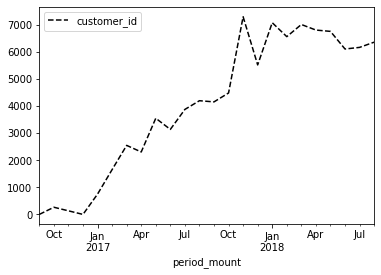

In [57]:
# Количество уникальных клиентов которые сделали хотя бы один заказ.
customer = delivered_order.groupby('period_mount',as_index=False).agg({'customer_id':'nunique'})
customer.plot(x='period_mount',y='customer_id',style='k--')

Метрика № 3  Заинтересованность новых клиентов в продукте

In [58]:
# Заинтересованность у новых пользователей есть только в нулевой месяц жизни в продукте,
# после чего они не видят для себя ценности в продукте и не возвращаеться.

Метрика № 4 Вовлеченность клиента в продукт

In [59]:
# Сколько пользователь совершил заказов
nuniq_customer=delivered_order.groupby('customer_id',as_index=False).agg({'order_id':'count'})
nuniq_customer

,customer_id,order_id
0,00012a2ce6f8dcda20d059ce98491703,1
1,000161a058600d5901f007fab4c27140,1
2,0001fd6190edaaf884bcaf3d49edf079,1
3,0002414f95344307404f0ace7a26f1d5,1
4,000379cdec625522490c315e70c7a9fb,1
...,...,...
96473,fffcb937e9dd47a13f05ecb8290f4d3e,1
96474,fffecc9f79fd8c764f843e9951b11341,1
96475,fffeda5b6d849fbd39689bb92087f431,1
96476,ffff42319e9b2d713724ae527742af25,1


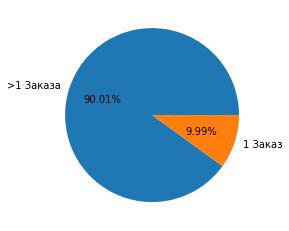

In [60]:
more_than_one =nuniq_customer.query("order_id >1 ").customer_id.nunique()
one_order = nuniq_customer.query("order_id ==1").customer_id.nunique()
sizes = [one_order, more_than_one]
labels = ['>1 Заказа','1 Заказ']
plt.pie(sizes, labels=labels, autopct='%.2f%%')
plt.show()

Метрика № 5 Денежное выражение вовлеченности клиента

In [61]:
# сумма стоимости всех заказов и количество уникальных пользователей по месецам
cost_of_all_orders_per_month= delivered_order.groupby('period_mount',as_index=False)\
                              .agg({'customer_unique_id':'nunique','price':'sum'})
cost_of_all_orders_per_month

,period_mount,customer_unique_id,price
0,2016-09,1,134.97
1,2016-10,262,40325.11
2,2016-12,1,10.90
3,2017-01,718,111798.36
4,2017-02,1630,234223.40
5,2017-03,2508,359198.85
6,2017-04,2274,340669.68
7,2017-05,3479,489338.25
8,2017-06,3076,421923.37
9,2017-07,3802,481604.52


In [62]:
# Считаю cредний чек
cost_of_all_orders_per_month['avg_cheak'] = cost_of_all_orders_per_month['price'] / cost_of_all_orders_per_month['customer_unique_id']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text major ticklabel objects>)

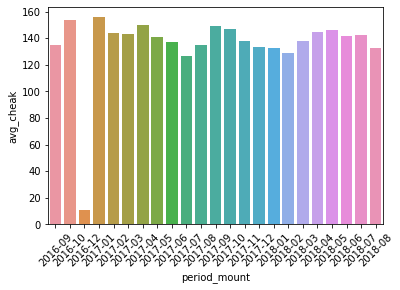

In [63]:
sns.barplot(data = cost_of_all_orders_per_month, x='period_mount' , y='avg_cheak' )
plt.xticks(rotation=45)

# Задание № 4
Выбрать одну из 3 основных гипотез с помощью фреймворка ICE.

# Гипотиза 1
 Если исправим баг в системе процессинга заказов, 
 то клиентам не придётся сталкиваться с проблемой отмены заказа,
 вследствие чего количество доставленных заказов увеличится.

In [64]:
# Объединаю два датасета
order_customers= olist_orders_dataset.merge(olist_customers_dataset, on='customer_id')

In [65]:
# Объединаю два датасета и фильтрую по доставленным заказам 
order_customers_items = olist_order_items_dataset.merge(order_customers, how = 'left', on = 'order_id')

In [66]:
# Структура данных по заказам
order_customers_items.groupby('order_status').agg({'order_id':'count'})

,order_id
order_status,
approved,3
canceled,542
delivered,110197
invoiced,359
processing,357
shipped,1185
unavailable,7


In [67]:
order_customers_items[order_customers_items['order_status'] == \
                      'canceled']['price'].sum()/ order_customers_items.price.sum()

0.007006898657886387

# Гипотиза 2
Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов.

In [68]:
# Преобразовываю даты 
order_customers_items['shipping_limit_date']= pd.to_datetime(order_customers_items['shipping_limit_date'])
order_customers_items['order_purchase_timestamp']= pd.to_datetime(order_customers_items['order_purchase_timestamp'])
order_customers_items['order_approved_at']= pd.to_datetime(order_customers_items['order_approved_at'])
order_customers_items['order_delivered_carrier_date']= pd.to_datetime(order_customers_items['order_delivered_carrier_date'])
order_customers_items['order_delivered_customer_date']= pd.to_datetime(order_customers_items['order_delivered_customer_date'])
order_customers_items['order_estimated_delivery_date']= pd.to_datetime(order_customers_items['order_estimated_delivery_date'])

In [69]:
order_customers_items=order_customers_items.query("order_status == 'delivered' & order_purchase_timestamp > '2017-05-31'")

In [70]:
#Сколько прошло с момента покупки заказа до передачи перевозчику 
order_customers_items['transfer_time'] = \
(order_customers_items['order_delivered_carrier_date'] - order_customers_items['order_purchase_timestamp'])

In [71]:
# Сколько по времени доставляли заказ 
order_customers_items['delivery'] =\
(order_customers_items['order_delivered_customer_date'] - order_customers_items['order_purchase_timestamp'])

In [72]:
# На сколько опоздал заказ относительно предпологаемой даты доставки 
order_customers_items['is_late'] = \
(order_customers_items['order_delivered_customer_date']-order_customers_items['order_estimated_delivery_date'])

In [73]:
# Время задержки 
order_customers_items['time_of_delay'] = order_customers_items['transfer_time']+order_customers_items['is_late']

In [74]:
# флаг опоздал заказ или нет
order_customers_items['flag'] = \
order_customers_items.order_estimated_delivery_date > order_customers_items.order_delivered_customer_date

In [75]:
# Количество опоздавших и пришедших вовремя 
order_customers_items.groupby('flag').order_id.count()

flag
False     8123
True     89650
Name: order_id, dtype: int64

In [76]:
# Доля опоздавших 
order_customers_items[order_customers_items['flag']== False]\
.customer_id.count()/order_customers_items.customer_id.count()*100 

8.308019596412098

In [77]:
# Доля в повторый заказ из пользователей к которым заказ не опаздал  
x=order_customers_items[order_customers_items['flag']== False]\
.groupby('customer_id',as_index=False)\
.agg({'order_id':'count'}).sort_values('order_id',ascending=False)

x[x['order_id']>1]['customer_id'].nunique()/x.customer_id.count()

0.07830253251197809

In [78]:
# Доля в повторый заказ из пользователей к которым заказ опаздал
xy=order_customers_items[order_customers_items['flag']== True]\
.groupby('customer_id',as_index=False)\
.agg({'order_id':'count'}).sort_values('order_id',ascending=False)

xy[xy['order_id']>1]['customer_id'].nunique()/xy.customer_id.count()

0.1020121187329021

In [79]:
order_customers_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,transfer_time,delivery,is_late,time_of_delay,flag
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,6 days 09:35:14,7 days 14:44:46,-9 days +23:43:48,-2 days +09:19:02,True
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,2018-02-05,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,1 days 22:03:17,7 days 22:45:45,-14 days +13:19:16,-12 days +11:22:33,True
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,2018-08-20,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,2 days 03:27:25,6 days 03:32:04,-6 days +13:32:39,-4 days +17:00:04,True
6,00054e8431b9d7675808bcb819fb4a32,1,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,19.90,11.85,32e2e6ab09e778d99bf2e0ecd4898718,delivered,2017-12-10 11:53:48,...,2018-01-04,635d9ac1680f03288e72ada3a1035803,16700,guararapes,SP,1 days 13:14:00,8 days 10:09:50,-17 days +22:03:38,-15 days +11:17:38,True
7,000576fe39319847cbb9d288c5617fa6,1,557d850972a7d6f792fd18ae1400d9b6,5996cddab893a4652a15592fb58ab8db,2018-07-10 12:30:45,810.00,70.75,9ed5e522dd9dd85b4af4a077526d8117,delivered,2018-07-04 12:08:27,...,2018-07-25,fda4476abb6307ab3c415b7e6d026526,11702,praia grande,SP,1 days 00:06:33,5 days 01:55:40,-16 days +14:04:07,-15 days +14:10:40,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,...,2018-05-18,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA,1 days 22:11:54,17 days 08:59:34,-8 days +22:56:40,-6 days +21:08:34,True
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,...,2018-08-01,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR,2 days 21:38:14,9 days 10:05:09,-9 days +20:31:55,-6 days +18:10:09,True
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,...,2017-11-10,cd79b407828f02fdbba457111c38e4c4,4039,sao paulo,SP,2 days 22:05:18,4 days 19:14:26,-13 days +12:22:22,-10 days +10:27:40,True
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,...,2017-08-25,eb803377c9315b564bdedad672039306,13289,vinhedo,SP,0 days 19:59:54,1 days 22:56:41,-9 days +21:59:40,-8 days +17:59:34,True


In [80]:
# группирую по штату  и делаю подгруппы  по опоздавшим заказам и не опоздавшим
grouped = order_customers_items.groupby(['customer_state','flag']).agg({'transfer_time':'count'})
grouped

transfer_time
customer_state flag                
AC             False              3
               True              63
AL             False             88
               True             265
AM             False              5
               True             124
AP             True              67
BA             False            467
               True            2784
CE             False            199
               True            1063
DF             False            171
               True            1975
ES             False            265
               True            1715
GO             False            170
               True            1855
MA             False            155
               True             534
MG             False            671
               True           10668
MS             False             86
               True             646
MT             False             60
               True             855
PA             False            127
               True             770
PB             False             60
               True             453
PE             False            171
               True            1393
PI             False             76
               True             374
PR             False            250
               True            4678
RJ             False           1756
               True           10668
RN             False             50
               True             406
RO             False              4
               True             217
RR             False              4
               True              32
RS             False            402
               True            5023
SC             False            335
               True            3257
SE             False             53
               True             247
SP             False           2458
               True           39296
TO             False             36
               True             222

In [81]:
total_sum = grouped['transfer_time'].sum()

In [82]:
# Считаю долю
grouped['share']=(grouped['transfer_time'] / total_sum) * 100

In [83]:
# доля  доставленных вовремя/True и опоздавшим/False заказам в разбивке по штатам
grouped.query("flag==False").sum()

transfer_time    8122.000000
share               8.307082
dtype: float64

# Гипотиза 3
Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ,
то клиенты не будут испытывать трудности при оформлении заказа, 
вследствие чего количество заказов увеличится за счёт повторных заказов.

In [84]:
order_customers_items['approved_time'] =(order_customers_items['order_approved_at']-order_customers_items['order_purchase_timestamp']).dt.days

In [85]:
# заказы у которых подтвердение оплаты дольше одного дня
late_payment_confirmation = order_customers_items.query("approved_time > 1 and order_status == 'delivered'").groupby('approved_time').order_id.count()

In [86]:
# доля заказов у которых подверждение оплаты происходило дольше 1 дня
(late_payment_confirmation/total_sum *100).sum()

5.324632819212045

In [87]:
late_payment_confirmation.sum()

5206

# ICE


In [88]:
# Гипотиза №1
4 * 8 * 6

192

In [89]:
# Гипотиза №2
8*10*4

320

In [90]:
# Гипотиза №3
7*5*9

315

# Задача № 5 
Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять.



In [91]:
# Целевая метрика - удержание клиента
# Прокси мерика - количество повторных заказов
# Guardrail метрика - средний чек


# Задача № 6
Сформулируйте выводы о проделанной работе

In [93]:
# Задача № 2
# На основании ретеншина продукт/маркетфит отсутствует. Низкий уровень возвращаемости  и отсутствие роста активности
# пользователей указывают на то, что продукт не соответствует потребностям рынка.
# Вывод: нужно сконцентрироваться на удержании клиентов в продукте.

# Задача № 3 # Сформировал 5 метрик на которые стоит сделать акцент.
    # Метрика № 1 Рост продаж.
    # Рост продаж наблюдаеться, но в дальшей пользователи из каждой когорты почти не делают повторных заказов.
    # Метрикка № 2 Количество уникальных пользователей.
    # Количество уникальных пользователей ростет с каждым месяцем, но удержание так же на околонулевом проценте.

    # Метрика № 3 Заинтересованность новых клиентов в продукте.
    # Заинтересованность у новых пользователей есть только в нулевой месяц жизни в продукте,
    # после чего они не видят для себя ценности в продукте и не возвращаються.

    # Метрика № 4  Вовлеченность клиента в продукт.
    # 10 % пользователей совершают повторный заказ.

    # Метрика № 5  Вовлеченность клиента в продукт
    # Учитываю рост продаж средний чек остаеться примено на одном уровне.

# Задача # 4
    # По фреймворку ICE вторая гипотиза набрала 320 баллов.
    # Я считаю что, реализация 2 гипотизы должно улучшить конверсию в повторных заказ,
    # так как заказы перестануть на долго задерживаться и люди будут больше заинтересованны в продукте, 
    # и тем самым увеличеться удержание пользователей в продукте.
    
# Задача № 5
    # Мной сформулированы метрики, на которые должна повлиять выбранная мной гипотеза.
    # Целевая метрика - удержание клиента
    # Прокси мерика - количество повторных заказов
    # Guardrail метрика - средний чек